--- Cost Decay Fit Results ---
C_start (2005): 26718.47
C_min (Floor): 80.82
Lambda (Annual): 0.1800
--- For constants.yaml ---
base_cost_usd_per_kg (2050): 88.90
min_cost_usd_per_kg: 80.82
decay_rate_monthly: 0.015001 (Annual: 0.1800)


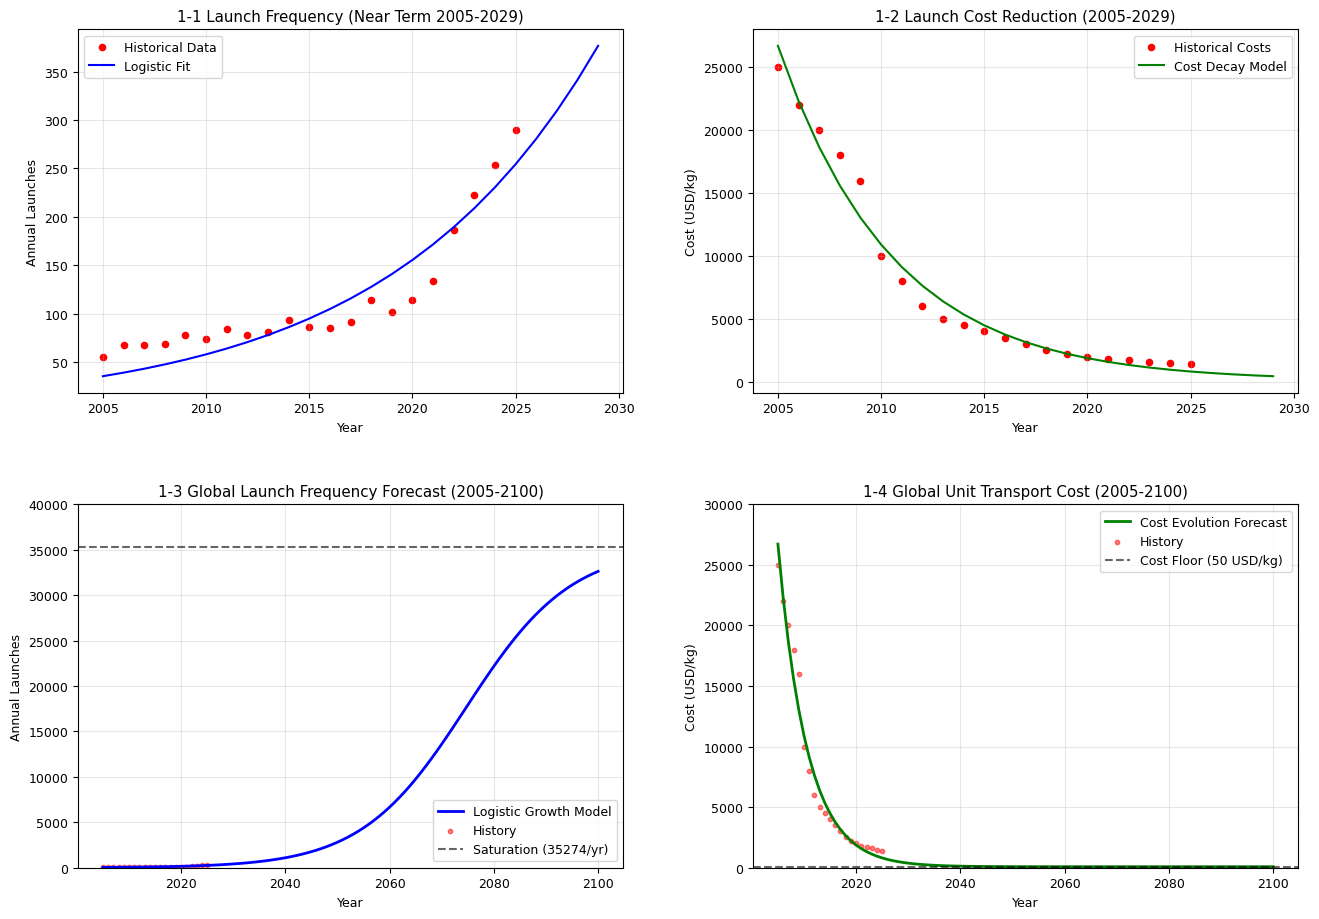

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 设置全局字体大小，防止重叠
plt.rcParams.update({'font.size': 9})

# --- 模型定义 ---
def logistic_func(t, K, A, r):
    t0 = 2005
    return K / (1 + A * np.exp(-r * (t - t0)))

def cost_decay_func(x, C_start, C_min, lam):
    t0 = 2005
    return (C_start - C_min) * np.exp(-lam * (x - t0)) + C_min

# --- 1. 准备数据 ---
# A. 近现代数据 (2005-2025 历史点 + 2026-2029 趋势)
years_short = np.arange(2005, 2030)
hist_years = np.arange(2005, 2026)
# 发射次数历史数据
# Global Orbital Launch Attempts 2005-2024 (Verified) + 2025 (Projected)
# Sources: spacestatsonline.com, nature.com, wikipedia
hist_launches = [
    55, 67, 68, 69, 78, 74, 84, 78, 81, 93,   # 2005-2014
    86, 85, 91, 114, 102, 114, 134, 186, 223, 254, # 2015-2024
    290 # 2025 projection
]
# Historical Cost (USD/kg to LEO) - Approximate Market Rates
# Reflects Shuttle era (~$20k+) -> Falcon 9 era (~$3k) -> Falcon Heavy/Reuse era (~$1.5k)
# Historical Cost (USD/kg to LEO) - Researched Market Rates (2005-2024)
# Sources: NASA, TT&C, CSIS, SpaceX Pricing
# 2005-2009: Shuttle/EELV Legacy (~$25k-$15k)
# 2010-2015: Falcon 9 Entry (~$10k-$4k)
# 2016-2024: Reusability Era (~$3k-$1.5k)
hist_costs = [
    25000, 22000, 20000, 18000, 16000, 10000, 8000, 6000, 5000, 4500, # 2005-2014
    4000, 3500, 3000, 2500, 2200, 2000, 1800, 1700, 1600, 1500,       # 2015-2024
    1400 # 2025 projection
]
# B. 远期预测数据 (2050-2100)
years_long = np.arange(2050, 2101)

# --- 2. 拟合计算 ---
# 1-1 发射次数拟合
# Bounds and initial guess for logistic fit (from calc_launch_prediction.py)
p0_freq = [3000, 50, 0.15]
bounds_freq = ([300, 0, 0], [50000, 1000, 1.0])
popt_freq, _ = curve_fit(
    logistic_func, hist_years, hist_launches, p0=p0_freq, bounds=bounds_freq
)
y_freq_fit = logistic_func(years_short, *popt_freq)

# 1-2 发射成本拟合 (2005-2029)
# C(t) = (C_start - C_min) * exp(-lam * (t - 2005)) + C_min
p0_cost = [25000, 100, 0.1] # Start 25k, Min 100, Decay 0.1
bounds_cost = ([5000, 0, 0.01], [50000, 2000, 1.0])

popt_cost_s, _ = curve_fit(cost_decay_func, hist_years, hist_costs, p0=p0_cost, bounds=bounds_cost)
C_start_2005, C_min, lam_annual = popt_cost_s

# Calculate parameters for constants.yaml (Base Year 2050)
year_target = 2050
t_diff = year_target - 2005
C_2050 = (C_start_2005 - C_min) * np.exp(-lam_annual * t_diff) + C_min
lam_monthly = lam_annual / 12.0

print(f"--- Cost Decay Fit Results ---")
print(f"C_start (2005): {C_start_2005:.2f}")
print(f"C_min (Floor): {C_min:.2f}")
print(f"Lambda (Annual): {lam_annual:.4f}")
print(f"--- For constants.yaml ---")
print(f"base_cost_usd_per_kg (2050): {C_2050:.2f}")
print(f"min_cost_usd_per_kg: {C_min:.2f}")
print(f"decay_rate_monthly: {lam_monthly:.6f} (Annual: {lam_annual:.4f})")

y_cost_s_fit = cost_decay_func(years_short, *popt_cost_s)

# 1-4 成本预测 (2005-2100) - Cost Decay (Full Range)
# Using the fitted parameters extended to 2100
y_cost_l_fit = cost_decay_func(years_full, *popt_cost_s)

# --- 3. 绘图 ---
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# [1-1] 发射次数验证 (2005-2029) - 局部放大
axs[0, 0].scatter(hist_years, hist_launches, color='red', s=20, label='Historical Data')
axs[0, 0].plot(years_short, y_freq_fit, 'b-', label=f'Logistic Fit')
axs[0, 0].set_title('1-1 Launch Frequency (Near Term 2005-2029)')
axs[0, 0].set_ylabel('Annual Launches')
axs[0, 0].legend()
axs[0, 0].grid(True, alpha=0.3)

# [1-2] 发射成本验证 (2005-2029)
axs[0, 1].scatter(hist_years, hist_costs, color='red', s=20, label='Historical Costs')
axs[0, 1].plot(years_short, y_cost_s_fit, 'g-', label='Cost Decay Model')
axs[0, 1].set_title('1-2 Launch Cost Reduction (2005-2029)')
axs[0, 1].set_ylabel('Cost (USD/kg)')
# axs[0, 1].set_yscale('log') # Removed to show curve
axs[0, 1].legend()
axs[0, 1].grid(True, alpha=0.3)

# [1-3] 发射次数预测 (2005-2100) - 全局 S 曲线
axs[1, 0].plot(years_full, y_launches_full, 'b-', linewidth=2, label='Logistic Growth Model')
axs[1, 0].scatter(hist_years, hist_launches, color='red', s=10, alpha=0.5, label='History')
axs[1, 0].axhline(y=popt_freq[0], color='black', linestyle='--', alpha=0.6, label=f'Saturation ({int(popt_freq[0])}/yr)')
axs[1, 0].set_title('1-3 Global Launch Frequency Forecast (2005-2100)')
axs[1, 0].set_ylabel('Annual Launches')
axs[1, 0].set_ylim(0, 40000)
axs[1, 0].legend(loc='lower right')
axs[1, 0].grid(True, alpha=0.3)

# [1-4] 成本预测 (2005-2100) - 全局视角
axs[1, 1].plot(years_full, y_cost_l_fit, 'g-', linewidth=2, label='Cost Evolution Forecast')
axs[1, 1].scatter(hist_years, hist_costs, color='red', s=10, alpha=0.5, label='History')
axs[1, 1].axhline(y=50, color='black', linestyle='--', alpha=0.6, label='Cost Floor (50 USD/kg)')
axs[1, 1].set_title('1-4 Global Unit Transport Cost (2005-2100)')
axs[1, 1].set_ylabel('Cost (USD/kg)')
# Log scale often better for long range cost decay, but linear shows "leveling off" well too.
# Let's keep linear but adjust limit to see the drop.
axs[1, 1].set_ylim(0, 30000) # Start from 25k, so 30k is good view
axs[1, 1].legend()
axs[1, 1].grid(True, alpha=0.3)

# 统一 X 轴标签并自动优化间距
for ax in axs.flat:
    ax.set_xlabel('Year')

plt.tight_layout(pad=4.0)
plt.show()